# Exploring RNNs
In this notebook, we will be creating a simple Elman-type recurrent neural network (RNN) followed by implementing backpropagation through time (BPTT) to train the RNN on 2D hand-drawn trajectories.

The Elman-type RNN is a 3-layered network with a recurrent hidden (context) layer, with the following structure:
- $\mathbf{x}_t$ as the input
- $\mathbf{c}_t$ as the internal state
- $\widehat{\mathbf{y}}_{t+1}$ as the output.

The network is defined by the following equations:
$$\begin{align*}
\mathbf{c}_{t+1} &= \boldsymbol{\theta}(\underbrace{\mathbf{W}^{cc}\mathbf{c}_t + \mathbf{W}^{cx}\mathbf{x}_{t} + \mathbf{b}^c}_{\mathbf{s}^c_{t+1}}) \\
\widehat{\mathbf{y}}_{t+1} &= \boldsymbol{\phi}(\underbrace{\mathbf{W}^{yc}\mathbf{c}_{t+1} + \mathbf{b}^y}_{\mathbf{s}^{y}_{t+1}}),
\end{align*}$$
where $\boldsymbol{\theta}(\cdot)$ and $\boldsymbol{\phi}(\cdot)$ are vectorized activation functions (e.g. ReLU and sigmoid) and $\mathbf{c}_0$ is a trainable initial context state that plays a key role in capturing the starting conditions of each trajectory.

We will use squared Euclidean distance from the trajectory at every timestep as the loss function to train the network:
$$E_t(\Omega) = ||\mathbf{y}_t - \widehat{\mathbf{y}}_t||^2, \quad t \geq 1$$
where the row vectors $\widehat{\mathbf{y}}_t$ and $\mathbf{y}_t$ are the predicted and target trajectory points, respectively, at timestep $t$, and $\Omega$ is the set of trainable model parameters (e.g. weights and biases) in our network.

## 1. Getting the Data
We will start with the preliminaries like importing the necessary libraries and creating a canvas to draw the training data. Datasets for different trajectory sequences can be created (hand-drawn) on this canvas.

In [635]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from ipycanvas import Canvas, hold_canvas
import ipywidgets as widgets
from IPython.display import display
import os
import pickle

In [2]:
canvas_width = 400
canvas_height = 400
canvas = Canvas(width=canvas_width, height=canvas_height)
bgcolor = "#D3D3D3" # lightgrey
canvas.fill_style = bgcolor
canvas.fill_rect(0, 0, canvas_width, canvas_height)
display(canvas)

traj = []
drawing = False

# event handlers
def handle_mouse_down(x, y):
    global drawing
    drawing = True
    traj.clear()  # start a new trajectory
    traj.append((x, y))
    
def handle_mouse_move(x, y):
    if drawing:
        if not traj:
            return
        # draw a line segment from the previous point to the current one
        prev_x, prev_y = traj[-1]
        with hold_canvas(canvas):
            canvas.stroke_line(prev_x, prev_y, x, y)
        traj.append((x, y))

def handle_mouse_up(x, y):
    global drawing
    if drawing:
        traj.append((x, y))
        drawing = False

canvas.on_mouse_down(handle_mouse_down)
canvas.on_mouse_move(handle_mouse_move)
canvas.on_mouse_up(handle_mouse_up)

# utility functions
def normalize_trajectory(trj):
    """normalize points to [0, 1] range"""
    normalized_traj = np.array(trj).astype(float)
    # flip y-axis to align with global coordinate system
    normalized_traj[:, 1] = canvas_height - normalized_traj[:, 1]
    # normalize
    normalized_traj[:, 0] /= canvas_width
    normalized_traj[:, 1] /= canvas_height
    return normalized_traj

def resample_trajectory(trj, num_points=100):
    """linearly resample a trajectory to have exactly num_points"""
    curr_traj = np.array(trj)
    original_indices = np.linspace(0, 1, len(curr_traj))
    new_indices = np.linspace(0, 1, num_points)
    resampled_traj = np.zeros((num_points, curr_traj.shape[1]))
    # interpolate each dimension independently
    for i in range(curr_traj.shape[1]):
        resampled_traj[:, i] = np.interp(new_indices, original_indices, curr_traj[:, i])
    return resampled_traj

# ui elements
file_name_text = widgets.Text(
    value='./data/new_trajectory.npz',
    description='File name:',
    placeholder='Enter file name...'
)

clear_button = widgets.Button(description="Clear Canvas")
def clear_canvas(b):
    canvas.clear()
    traj.clear()
    canvas.fill_rect(0, 0, canvas_width, canvas_height)
clear_button.on_click(clear_canvas)

save_button = widgets.Button(description="Save Trajectory")
def save_trajectory(b):
    if len(traj) < 2:
        print("Not enough points drawn. Please draw a trajectory first.")
        return
    curr_traj = np.array(traj)
    traj_normalized = normalize_trajectory(curr_traj)
    traj_resampled = resample_trajectory(traj_normalized, num_points=100)
    file_path = file_name_text.value
    directory = os.path.dirname(file_path)
    if directory and not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
    np.savez(file_name_text.value, trajectory=traj_resampled)
    print("Trajectory saved to {}".format(file_path))

save_button.on_click(save_trajectory)

# display widgets
display(widgets.HBox([clear_button, file_name_text, save_button]))

Canvas(height=400, width=400)

## 2. Implementing the RNN
### 2.1 Preliminaries
The forward pass of the network is defined in the section above. We will begin by creating the loss and activation function classes as well as the overall `RNN` class with dense fully connected input, output, and a stateful hidden context layer.

In [3]:
# activation functions
class ReLU:
    # relu = max(x, 0)
    @staticmethod
    def __call__(x):
        return np.maximum(x, 0)
    # derivative of relu
    @staticmethod
    def prime(x):
        return np.where(x > 0.0, 1.0, 0.0)

class Sigmoid:
    # sigmoid = 1 / (1 + exp(-x))
    @staticmethod
    def __call__(x):
        return 1/(1 + np.exp(-x))
    # derivative of sigmoid
    @staticmethod
    def prime(x):
        sigmoid = Sigmoid()(x)
        return sigmoid*(1 - sigmoid)
    
class Tanh:
    # tanh = (exp(x) - exp(-x)) / (exp(x) + exp(-x))
    @staticmethod
    def __call__(x):
        return np.tanh(x)
    # derivative of tanh
    @staticmethod
    def prime(x):
        return 1 - np.tanh(x)**2
    
class Linear:
    # linear = x
    @staticmethod
    def __call__(x):
        return x
    # derivative of linear
    @staticmethod
    def prime(x):
        return np.ones_like(x)

We will denote an individual weight $w^{ab}_{i,j}$ to be along an edge connecting node $j$ in layer $b$ to node $i$ in layer $a$, representing an entry in the corresponding weight matrix $\mathbf{W}^{ab}$ under conventional row-column indexing. The preactivation input at layer $a$ is given by $\mathbf{s}^{a} = \mathbf{W}^{ab}\mathbf{x}^{b} + \mathbf{b}^{a}$ with the corresponding layer activation $\mathbf{x}^{a} = \boldsymbol{\theta}^{a}(\mathbf{s}^a)$.

To prompt effective and stable learning in simple RNNs, we follow this [paper](https://arxiv.org/abs/1511.03771v3) to initialize all weights. Accordingly, the feedforward weights $\mathbf{W}^{cx} \in \mathbb{R}^{n_c \times n_x}$ are drawn independently from a zero-mean Gaussian distribution with variance $1/{n_c}$, and are further scaled by a factor $$\alpha = \sqrt{2}\exp\left(\frac{1.2}{\max(n_c, 6)-2.4}\right).$$
Similarly, the weights $\mathbf{W}^{yc} \in \mathbb{R}^{n_y \times n_c}$ follow the Xavier (Glorot) initialization scheme and are drawn independently from a Gaussian distribution with variance $2/(n_c+n_y)$.
The recurrent weights $\mathbf{W}^{cc} \in \mathbb{R}^{n_c \times n_c}$ are initialized to form a positive-definite (random) matrix with the highest eigenvalue of unity. Specifically, starting with a standard normal matrix $\mathbf{R} \in \mathbb{R}^{n_c \times n_c}$, we perform the following computations:
$$\begin{align*}
\mathbf{P} &= \mathbf{I} + \frac{\mathbf{R}^\top\mathbf{R}}{n_c} \\
\mathbf{W}^{cc} &= \frac{\mathbf{P}}{\max\left(\lambda\left(\mathbf{P}\right)\right)},
\end{align*}$$
where $\lambda(\mathbf{P})$ is the set of all eigenvalue magnitudes of matrix $\mathbf{P}$. All the biases are set to zero. All entries in the initial context vectors $\mathbf{c}_0$ are drawn independently from a zero-mean Gaussian distribution with variance $1/{n_c}$.

In [4]:
class RNN:
    """
    simple RNN with one hidden, stateful context layer that is trainable for multiple sequences with shared 
    weights and biases but different starting contexts
    """
    def __init__(self, input_dim, hidden_dim, output_dim, activations, seqIDs=[]):
        # seqIDs needed to store sequence-wise initial contexts
        # network parameters are initialized according to https://arxiv.org/abs/1511.03771v3
        assert len(activations) == 2 and input_dim == output_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.activations  = activations
        self.seqIDs = seqIDs

        # Wcx: i.i.d. entries ~ scaled Gaussian distribution (mu=0, sigma^2=1/hidden_dim, scaled by alpha)
        alpha = np.sqrt(2) * np.exp(1.2/(max(hidden_dim, 6) - 2.4))
        self.Wcx = (alpha/np.sqrt(hidden_dim)) * np.random.randn(hidden_dim, input_dim)

        # Wcc: initialized to a random positive-definite matrix with highest eigval of unity
        R = np.random.randn(hidden_dim, hidden_dim)
        P = np.eye(hidden_dim) + (R.T @ R) / hidden_dim
        e = np.max(np.abs(np.linalg.eigvals(P)))
        self.Wcc = P / e

        # Wyc: i.i.d. entries ~ Gaussian distribution (mu=0, sigma^2=2/(n_in+n_out))
        # this scheme is also known as the Xavier or Glorot initialization
        self.Wyc = np.random.randn(output_dim, hidden_dim) / np.sqrt((output_dim+hidden_dim)/2)

        # initialize biases (according to the Glorot scheme)
        self.bc = np.zeros((hidden_dim,), dtype=float)
        self.by = np.zeros((output_dim,), dtype=float)

        # dictionary of initial contexts for each sequence (and its copy for stateful compute)
        self.c0 = {seqID: np.random.randn(hidden_dim,)/np.sqrt(hidden_dim) for seqID in seqIDs}
        self.ct = {seqID: np.copy(self.c0[seqID]) for seqID in seqIDs}

    def add_seqID(self, seqID):
        self.seqIDs.append(seqID)
        self.c0[seqID] = np.random.randn(self.hidden_dim,)/np.sqrt(self.hidden_dim)
        self.ct[seqID] = np.copy(self.c0[seqID])

    def remove_seqID(self, seqID):
        self.seqIDs.remove(seqID)
        del self.c0[seqID]
        del self.ct[seqID]

    def get_c0(self, seqID):
        assert seqID in self.seqIDs
        return np.copy(self.c0[seqID])

    def get_ct(self, seqID):
        assert seqID in self.seqIDs
        return np.copy(self.ct[seqID])

    def step_stateless(self, x, c):
        """perform a single step of forward propagation (memoryless)"""
        cnxt = self.activations[0](self.Wcx @ x + self.Wcc @ c + self.bc)
        ynxt = self.activations[1](self.Wyc @ cnxt + self.by)
        return ynxt, cnxt

    def step_stateful(self, x, seqID):
        """perform a single step of forward propagation (with memory)"""
        assert seqID in self.seqIDs
        sc = self.Wcx @ x + self.Wcc @ self.ct[seqID] + self.bc
        self.ct[seqID] = self.activations[0](sc)
        sy = self.Wyc @ self.ct[seqID] + self.by
        y = self.activations[1](sy)
        return sc, sy, np.copy(self.ct[seqID]), y

    def update_c0(self, c0, seqID):
        assert seqID in self.seqIDs
        self.c0[seqID] = np.copy(c0)
        self.reset_ct(seqID)

    def reset_ct(self, seqID):
        assert seqID in self.seqIDs
        self.ct[seqID] = self.get_c0(seqID)

    def fwd_prop(self, x, T, seqID):
        """
        forward propagation over next T time steps by closing the input-output loop
        output: yt = [y_0|y_1| ... |y_T], ct = [c_0|c_1| ... |c_T]
        """
        c = self.get_c0(seqID)
        yt = np.concatenate((x.reshape(-1,1), np.zeros((self.output_dim, T))), axis=1)
        ct = np.concatenate((c.reshape(-1,1), np.zeros((self.hidden_dim, T))), axis=1)
        for t in range(1, T+1):
            yt[:, t], ct[:, t] = self.step_stateless(yt[:, t-1], ct[:, t-1])
        return yt, ct

The accuracy of the network at any instant will be estimated by calculating the mean loss (i.e. mean of deviation errors at each timestep) over the entire sequence length given a fixed set of parameters, 
$$E_\text{mean} = \frac{1}{T}\sum_{1 \leq t \leq T} E_t(\Omega).$$

In [5]:
# step loss and mean loss functions
class Loss:
    def __call__(self, *args, **kwargs):
        raise NotImplementedError
    
    def prime(self, *args, **kwargs):
        raise NotImplementedError

class SquaredNorm(Loss):
    # loss = ||y - yhat||^2 for y, yhat in R^ny (output_dim)
    @staticmethod
    def __call__(y, yhat):
        return np.sum((y - yhat)**2) # current squared error
    
    # derivative with respect to input (yhat)
    @staticmethod
    def prime(y, yhat):
        return 2*(yhat - y)

def meanloss(ys, yshat):
    """expects ys and yshat to be of shape (output_dim, T+1)"""
    assert ys.shape == yshat.shape and ys.shape[1] > 1
    return np.sum((ys[:, 1:] - yshat[:, 1:])**2) / ys.shape[1]

We will run a forward pass on an untrained, newly initialized network and test for its accuracy to see if our implementation is functional thus far. We source the data from section 3 just for this purpose.

Mean loss: 0.6522


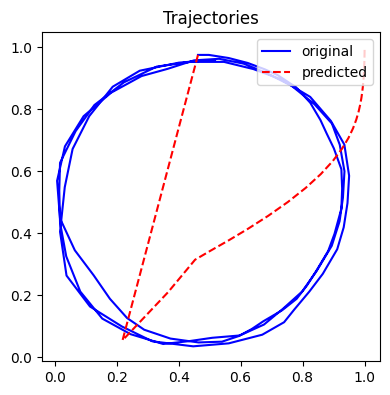

In [411]:
# test forward propagation and loss functions
rnn = RNN(2, 2, 2, [Linear(), Sigmoid()], seqIDs=['test-run'])
circ_traj = np.load('./data/circle1.npz')['trajectory'].T
pred_traj, _ = rnn.fwd_prop(circ_traj[:, 0], circ_traj.shape[1]-1, 'test-run')
loss = meanloss(circ_traj, pred_traj)
print("Mean loss: {:.4f}".format(loss))
# plot the trajectories for comparison
plt.figure(figsize=(4, 4))
plt.plot(circ_traj[0], circ_traj[1], 'b-', label='original')
plt.plot(pred_traj[0], pred_traj[1], 'r--', label='predicted')
plt.title('Trajectories')
plt.legend(loc='upper right')
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

### 2.2 BPTT Derivation and Implementation
Here we will use a particular style of BPTT for RNNs, called Teacher Forcing, wherein by providing true inputs at each timestep the output is sought to be aligned to the input sequence. To ensure good generalization, we will train on multiple sequences of the _same kind_.

BPTT involves unrolling the recurrent network by repeating the hidden layer (in the corresponding feedforward computational graph) to calculate the output for the next timestep. Based on the error following each timestep, new gradients are backpropagated and are eventually accumulated to update all trainable parameters in the network based on sequence prediction (or regeneration) errors. Below, we lay out the recursive backpropagation equations along with the base case for the input layer.

Following the delta-rule for backpropagating errors through feedforward networks with element-wise layer activations, we define
$\boldsymbol{\delta}^a_\tau \coloneqq \frac{\partial E_{t\geq\tau}}{\partial \mathbf{s}^a_\tau}$. In the base case, we compute the gradients based on the first (feedforward) prediction step of the network, i.e. for $T=1$:
$$\begin{align*}
\boldsymbol{\delta}^y_1 = \boldsymbol{\phi}^\prime&\left(\mathbf{s}_1^y\right)\odot\frac{\partial E_1}{\partial \widehat{\mathbf{y}}_1} \tag{o1}\\
\frac{\partial E_1}{\partial \mathbf{W}^{yc}} = \boldsymbol{\delta}^y_1&\mathbf{c}_1^\top, \quad \frac{\partial E_1}{\partial \mathbf{b}^{y}} = \boldsymbol{\delta}^y_1 \tag{o2}\\
\boldsymbol{\delta}^c_1 = \boldsymbol{\theta}^\prime&\left(\mathbf{s}_1^c\right) \odot \mathbf{W}^{yc\top}\boldsymbol{\delta}^y_1 \tag{o3}
\end{align*}$$
$$\begin{equation*}
\boxed{
\frac{\partial E_{t \geq 0}}{\partial \mathbf{W}^{cc}} = \boldsymbol{\delta}^c_1\mathbf{c}_0^\top, \quad \frac{\partial E_{t \geq 0}}{\partial \mathbf{W}^{cx}} = \boldsymbol{\delta}^c_1\mathbf{x}_0^\top, \quad \frac{\partial E_{t \geq 0}}{\partial \mathbf{b}^{c}} = \boldsymbol{\delta}^c_1, \quad \frac{\partial E_{t \geq 0}}{\partial \mathbf{c}_0} = \mathbf{W}^{cc\top}\boldsymbol{\delta}^c_1.
}
\tag{i1}
\end{equation*}$$

The case for $T>1$ (here shown for $T=2$) becomes:
$$\begin{align*}
\boldsymbol{\delta}^y_2 = \boldsymbol{\phi}^\prime\left(\mathbf{s}_2^y\right)&\odot\frac{\partial E_2}{\partial \widehat{\mathbf{y}}_2} \\
\frac{\partial E_2}{\partial \mathbf{W}^{yc}} = \boldsymbol{\delta}^y_2\mathbf{c}_2^\top&, \quad \frac{\partial E_2}{\partial \mathbf{b}^{y}} = \boldsymbol{\delta}^y_2\\
\boldsymbol{\delta}^c_2 = \boldsymbol{\theta}^\prime\left(\mathbf{s}_2^c\right)&\odot\mathbf{W}^{yc\top}\boldsymbol{\delta}^y_2 \\[4mm]
\frac{\partial E_2}{\partial \mathbf{W}^{cc}} = \boldsymbol{\delta}^c_2\mathbf{c}_1^\top, \quad \frac{\partial E_2}{\partial \mathbf{W}^{cx}} &= \boldsymbol{\delta}^c_2\mathbf{x}_1^\top, \quad \frac{\partial E_2}{\partial \mathbf{b}^{c}} = \boldsymbol{\delta}^c_2 \tag{h1 a}\\[2mm]
\quad \boldsymbol{\delta}^y_1 = \boldsymbol{\phi}^\prime(\mathbf{s}^y_1) \odot \frac{\partial E_1}{\partial \widehat{\mathbf{y}}_1}, \quad \frac{\partial E_1}{\partial \mathbf{W}^{yc}} &= \boldsymbol{\delta}^y_1\mathbf{c}^\top_1, \quad \frac{\partial E_1}{\partial \mathbf{b}^{y}} = \boldsymbol{\delta}^y_1 \tag{h1 b}\\[2mm]
\boldsymbol{\delta}^c_1 = \boldsymbol{\theta}^\prime\left(\mathbf{s}_1^c\right)\odot\Big(\mathbf{W}^{cc\top}&\boldsymbol{\delta}^c_2 + \mathbf{W}^{yc\top}\boldsymbol{\delta}^y_1\Big) \tag{h2}
\end{align*}$$
$$\ldots \quad \text{invoke base case above (i1).}$$

Note that all the same-parameter gradients are summed over backpropagation for each timestep and the entire unrolling, and are appropriately normalized to the running-sequence length.

### 2.3 Fine-tuning
Although many ways to fine-tune RNNs exist and can be further envisioned, for now, we will initially train the network using the teacher forcing paradigm and then move to unrolling the network by feeding back its previous output and applying the corresponding backpropagation of errors at each step. This will also require slightly modified gradients than derived above. The change particularly lies in tying the gradients for the output layer to the next hidden layer since $\mathbf{x}_t = \widehat{\mathbf{y}}_t$ for $t \geq 1$. Therefore, equations $(\text{h}1)$ and $(\text{h}2)$ need to be updated to the following for $1 \leq \tau \leq t-1$:
    $$\begin{align*}
    \frac{\partial E_{t \geq \tau+1}}{\partial \mathbf{W}^{cc}} = \boldsymbol{\delta}^c_{\tau+1}\mathbf{c}_\tau^\top, \quad &\frac{\partial E_{t \geq \tau+1}}{\partial \mathbf{W}^{cx}} = \boldsymbol{\delta}^c_{\tau+1}\widehat{\mathbf{y}}_\tau^\top, \quad \frac{\partial E_{t \geq \tau+1}}{\partial \mathbf{b}^{c}} = \boldsymbol{\delta}^c_{\tau+1} \tag{h\(1^\prime\) a}\\[2mm]
    \boldsymbol{\delta}^y_\tau = \boldsymbol{\phi}^\prime(\mathbf{s}^y_\tau) \odot \bigg(\frac{\partial E_\tau}{\partial \widehat{\mathbf{y}}_\tau} + \mathbf{W}^{cx\top}&\boldsymbol{\delta}^c_{\tau+1}\bigg), \quad \frac{\partial E_{t \geq \tau}}{\partial \mathbf{W}^{yc}} = \boldsymbol{\delta}^y_{\tau}\mathbf{c}^\top_\tau, \quad \frac{\partial E_{t \geq \tau}}{\partial \mathbf{b}^{y}} = \boldsymbol{\delta}^y_\tau \tag{h\(1^\prime\) b} \\[4mm]
    \boldsymbol{\delta}^c_\tau = \frac{\partial \mathbf{c}_\tau}{\partial \mathbf{s}^c_\tau}\frac{\partial \mathbf{s}^c_{\tau+1}}{\partial \mathbf{c}_\tau}\frac{\partial E_{t \geq \tau+1}}{\partial \mathbf{s}^c_{\tau+1}} + &\frac{\partial \mathbf{c}_\tau}{\partial \mathbf{s}^c_\tau}\frac{\partial \mathbf{s}^y_\tau}{\partial \mathbf{c}_\tau}\frac{\partial \widehat{\mathbf{y}}_\tau}{\partial \mathbf{s}^y_\tau}\left(\frac{\partial E_\tau}{\partial \widehat{\mathbf{y}}_\tau} + \frac{\partial \mathbf{s}^c_{\tau+1}}{\partial \widehat{\mathbf{y}}_\tau}\frac{\partial E_{t \geq \tau+1}}{\partial \mathbf{s}^c_{\tau+1}}\right) \\
    = \boldsymbol{\theta}^\prime\left(\mathbf{s}_\tau^c\right)\odot\Big(\mathbf{W}^{cc\top}\boldsymbol{\delta}^c_{\tau+1} &+ \mathbf{W}^{yc\top}\boldsymbol{\delta}^y_\tau\Big). \tag{h\(2^\prime\)}
    \end{align*}$$

We will now implement BPTT and then write the network training loop in the next section.

In [155]:
def bptt(self, seqID, ys, loss_fn, T, fine_tune):
    assert T >= 1 and ys.shape[1] >= T+1
    assert isinstance(loss_fn, Loss)
    # fwd prop states over T steps: {input x, context c} (T+1 steps), {sc, sy, yhat} (T+1 steps; first is zero)
    xt = np.concatenate((ys[:, 0].reshape(-1,1), np.zeros((self.input_dim, T))), axis=1)
    c0 = self.get_c0(seqID)
    ct = np.concatenate((c0.reshape(-1,1), np.zeros((self.hidden_dim, T))), axis=1)
    sct = np.zeros((self.hidden_dim, T+1)) # padded with zeros for t=0
    syt = np.zeros((self.output_dim, T+1)) # padded with zeros for t=0
    yhats = np.zeros((self.output_dim, T+1)) # padded with zeros for t=0
    for t in range(1, T+1):
        sct[:, t], syt[:, t], ct[:, t], yhats[:, t] = self.step_stateful(xt[:, t-1], seqID)
        if fine_tune:
            xt[:, t] = yhats[:, t] # close the loop with self-predicted input
        else:
            xt[:, t] = ys[:, t] # pass true input through the loop

    # initialize gradients
    grad_weights = {param: np.zeros_like(getattr(self, param)) for param in ['Wcx', 'Wcc', 'Wyc']}
    grad_biases = {param: np.zeros_like(getattr(self, param)) for param in ['bc', 'by']}
    grad_c0 = np.zeros_like(c0)

    # backprop through time (starting from tau = T)
    # gradients in immediate association with output (i.e. eqns o1, o2, and o3)
    delta_y_t = self.activations[1].prime(syt[:, T]) * loss_fn.prime(ys[:, T], yhats[:, T])
    grad_weights['Wyc'] += np.outer(delta_y_t, ct[:, T])
    grad_biases['by'] += delta_y_t
    delta_c_t = self.activations[0].prime(sct[:, T]) * (self.Wyc.T @ delta_y_t)
    # intermediate gradients (i.e. eqns h1 and h2)
    for tau in range(T-1, 0, -1): # tau = T-1, ..., 1
        # eqn h1a
        grad_weights['Wcc'] += np.outer(delta_c_t, ct[:, tau])
        grad_weights['Wcx'] += np.outer(delta_c_t, xt[:, tau])
        grad_biases['bc'] += delta_c_t
        # eqn h1b
        if fine_tune:
            delta_y_t = self.activations[1].prime(syt[:, tau]) * (
                loss_fn.prime(ys[:, tau], yhats[:, tau]) + self.Wcx.T @ delta_c_t
            )
        else:
            delta_y_t = self.activations[1].prime(syt[:, tau]) * loss_fn.prime(ys[:, tau], yhats[:, tau])
        grad_weights['Wyc'] += np.outer(delta_y_t, ct[:, tau])
        grad_biases['by'] += delta_y_t
        # eqn h2
        delta_c_t = self.activations[0].prime(sct[:, tau]) * (self.Wcc.T @ delta_c_t + self.Wyc.T @ delta_y_t)
    # input end gradients (i.e. eqn i1)
    grad_weights['Wcc'] += np.outer(delta_c_t, ct[:, 0]) # tau = 0
    grad_weights['Wcx'] += np.outer(delta_c_t, xt[:, 0]) # tau = 0
    grad_biases['bc'] += delta_c_t
    grad_c0 += self.Wcc.T @ delta_c_t

    return grad_weights, grad_biases, grad_c0

# expand network class definition
RNN.bptt = bptt

## 3. Fitting to the Data

### 3.1 Training and Applying Gradients
The training parameters (i.e. weights, biases, and the initial context) will be updated iteratively based on the (reverse) Cesàro mean loss using the following gradient-descent rule:

$$\begin{equation*}
\Omega_{k+1} = \Omega_{k} - \alpha_T\sum_{0 \leq \tau \leq T}\frac{\partial E_{t \geq \tau}}{\partial \Omega_k},
\end{equation*}$$

where $\alpha_T>0$ is the prediction-length adjusted learning rate and $k$ is the iteration or epoch number. As a simple extension, momentum-based gradient updates can also be applied during training. However, for the current purpose, we will only implement the basic form of gradient descent as described above.

In [317]:
def apply_grad_c0(self, seqID, grad_c0, alpha):
    # update initial contexts
    self.update_c0(self.get_c0(seqID) - alpha * grad_c0, seqID)

def apply_grad_weights_biases(self, grad_weights, grad_biases, alpha):
    # update weights and biases
    for param in grad_weights.keys():
        setattr(self, param, getattr(self, param) - alpha * grad_weights[param])
    for param in grad_biases.keys():
        setattr(self, param, getattr(self, param) - alpha * grad_biases[param])

# expand network class definition
RNN.apply_grad_c0 = apply_grad_c0
RNN.apply_grad_weights_biases = apply_grad_weights_biases

We now write the generic training loop for our network.

In [318]:
def train(self, seq_ys, loss_fn, T=33, epochs=1000, alpha=0.01, fine_tune=False):
    assert len(seq_ys) == len(self.seqIDs)
    alpha = alpha / T # sequence-length adjusted learning rate
    loss_hist = np.zeros(epochs, float) # loss history

    # train
    for epoch in range(epochs):
        grad_weights = {param: np.zeros_like(getattr(self, param)) for param in ['Wcx', 'Wcc', 'Wyc']}
        grad_biases = {param: np.zeros_like(getattr(self, param)) for param in ['bc', 'by']}
        # loop through seqIDs per epoch
        for seq, seqID in enumerate(self.seqIDs):
            # backpropagation through time
            grad_ws, grad_bs, grad_c0 = self.bptt(seqID, seq_ys[seq], loss_fn, T, fine_tune)
            # accumulate gradients
            for key in grad_weights.keys():
                grad_weights[key] += grad_ws[key]/len(self.seqIDs)
            for key in grad_biases.keys():
                grad_biases[key] += grad_bs[key]/len(self.seqIDs)
            # update initial context state
            self.apply_grad_c0(seqID, grad_c0, alpha)
        # apply gradient descent
        self.apply_grad_weights_biases(grad_weights, grad_biases, alpha)

        # compute mean loss (~indicative of accuracy) over the entire trajectory
        for seq, seqID in enumerate(self.seqIDs):
            yhat, _ = self.fwd_prop(seq_ys[seq][:, 0], T, seqID)
            loss_hist[epoch] += meanloss(seq_ys[seq][:, 0:T+1], yhat)/len(self.seqIDs)

        # print progress
        if epoch == 0 or epoch % 500 == 0:
            print(f"Epoch {epoch} | Net training loss: {loss_hist[epoch]}")

    return loss_hist

# expand network class definition
RNN.train = train

In [319]:
def plot_loss_history(loss_hist, title="Loss History"):
    """loss_hist: numpy array of shape (epochs,)"""
    plt.figure(figsize=(5, 3))
    plt.plot(np.arange(1, len(loss_hist)+1), loss_hist)
    # add lables and title
    plt.xlabel("Epochs")
    plt.ylabel("Mean Loss")
    plt.title(title)
    return plt.tight_layout()

As an example below, we train the network on circular trajectories. Note that in besides a progressive training schedule, one can also implement momentum-based and adaptive gradient descent strategies for robustness across training instances.

Epoch 0 | Net training loss: 0.18284298153170134
Epoch 500 | Net training loss: 0.16695389033720204
Epoch 1000 | Net training loss: 0.08461186219812242
Epoch 1500 | Net training loss: 0.02280941222279294
Epoch 2000 | Net training loss: 0.021093296481702484
Epoch 2500 | Net training loss: 0.020645535707278184
Epoch 3000 | Net training loss: 0.01579130176559018
Epoch 3500 | Net training loss: 0.012981587948998168
Epoch 4000 | Net training loss: 0.011609696133084227
Epoch 4500 | Net training loss: 0.010369060039686804
Epoch 5000 | Net training loss: 0.009215485549592232
Epoch 5500 | Net training loss: 0.008161857479911347
Epoch 6000 | Net training loss: 0.007216050205309568
Epoch 6500 | Net training loss: 0.006378012745392025
Epoch 7000 | Net training loss: 0.005641983593073755
Epoch 7500 | Net training loss: 0.004999072164005125
Epoch 8000 | Net training loss: 0.004439186108794312
Epoch 8500 | Net training loss: 0.003952233628010816
Epoch 9000 | Net training loss: 0.003528773968086089
Ep

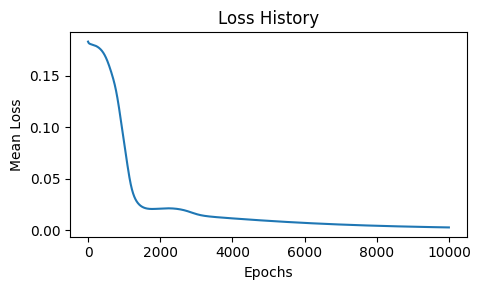

In [625]:
circle1 = np.load('./data/circle1.npz')['trajectory'].T
circle2 = np.load('./data/circle2.npz')['trajectory'].T
circle3 = np.load('./data/circle3.npz')['trajectory'].T
circle_rnn = RNN(2, 2, 2, [Sigmoid(), Sigmoid()], seqIDs=['circle1', 'circle2', 'circle3'])
circs = [circle1, circle2, circle3]
loss_hist = circle_rnn.train(circs, SquaredNorm(), T=15, alpha=0.25, epochs=10000, fine_tune=False)
plot_loss_history(loss_hist)

In the next example, we consider the number `8` (or the shape of a ribbon tie). To stabilize and robustify training, we will chop up the original sequence into multiple overlapping segments and shorten the unique points to the first 80 steps in the original ribbon drawing. But we will still test the trained RNN on the entire original sequence from its initial position.

In [321]:
# create a mini batch to stabilize training
def segment_trajectory(ys, batchsize=9, T=10, overlap=5):
    uniqueidxs = (batchsize-1)*(T-overlap) + (T+1) # unique indices init from 0
    assert overlap < T and batchsize > 1 and ys.shape[1] >= uniqueidxs
    segments = [None]*batchsize
    for i in range(batchsize):
        start = i*(T - overlap)
        end = start + (T + 1)
        segments[i] = np.copy(ys[:, start:end])
    return segments

ribbon = np.load('./data/eight.npz')['trajectory'].T
ribbon_segments = segment_trajectory(ribbon, batchsize=15)

Epoch 0 | Net training loss: 0.07514109637282583
Epoch 500 | Net training loss: 0.05720164084394443
Epoch 1000 | Net training loss: 0.04881941049486193
Epoch 0 | Net training loss: 0.045168693488969576
Epoch 500 | Net training loss: 0.04420205114033656
Epoch 1000 | Net training loss: 0.04324914971823758
Epoch 0 | Net training loss: 0.040562739598361146
Epoch 500 | Net training loss: 0.006648165885392932
Epoch 1000 | Net training loss: 0.003958057735082389
Epoch 1500 | Net training loss: 0.003011339480649218
Epoch 2000 | Net training loss: 0.002544499935772725
Epoch 2500 | Net training loss: 0.0022022100872726943
Epoch 0 | Net training loss: 0.002045779045264879
Epoch 500 | Net training loss: 0.0019410313205598093
Epoch 1000 | Net training loss: 0.0018839512302617474
Epoch 1500 | Net training loss: 0.0018226320420904358
Epoch 2000 | Net training loss: 0.0017745218269502186
Epoch 2500 | Net training loss: 0.001731767029535592
Epoch 3000 | Net training loss: 0.0016931811999151354
Epoch 35

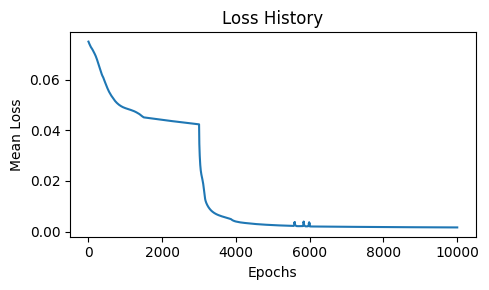

In [ ]:
ribbon_rnn = RNN(2, 10, 2, [ReLU(), Sigmoid()], seqIDs=['r'+str(i) for i in range(len(ribbon_segments))])
# progressive training schedule (as a sequence of α, epochs, fine_tune)
hyperparams = [(0.05, 1500, False), (0.01, 1500, False), (0.025, 3000, True), (0.01, 4000, True)]
loss_hist = np.zeros(0, float)
for alpha, epochs, fine_tune in hyperparams:
    hist = ribbon_rnn.train(
        ribbon_segments, SquaredNorm(), T=ribbon_segments[0].shape[1]-1, alpha=alpha, epochs=epochs, fine_tune=fine_tune
    )
    loss_hist = np.concatenate((loss_hist, hist))
plot_loss_history(loss_hist)

Finally, we consider two local circles and train over them as separate sequences to see the partioning of space into two local attractors.

In [ ]:
loccircle1 = np.load('./data/localcircle1.npz')['trajectory'].T
loccircle2 = np.load('./data/localcircle2.npz')['trajectory'].T
loccircle_rnn = RNN(2, 8, 2, [ReLU(), Sigmoid()], seqIDs=['circle1', 'circle2'])
localcircs = [loccircle1, loccircle2]
# progressive training schedule (as a sequence of T, α, epochs, fine_tune)
hyperparams = [(15, 0.075, 2000, False), (25, 0.1, 2000, True), (33, 0.075, 3000, True), (35, 0.05, 3000, True)]
loss_hist = np.zeros(0, float)
for T, alpha, epochs, fine_tune in hyperparams:
    hist = loccircle_rnn.train(localcircs, SquaredNorm(), T=T, alpha=alpha, epochs=epochs)
    loss_hist = np.concatenate((loss_hist, hist))

0.0006027348636564703


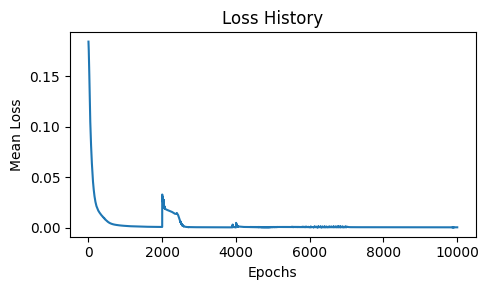

In [590]:
print(loss_hist[-1])
plot_loss_history(loss_hist)

## 4. "Generating" the Data: Autonomous Dynamical System


Using the trained RNNs, we can now regenerate the training trajectories and then compare them with the original.

Circle 1 Mean Loss: 0.1375
Circle 2 Mean Loss: 0.1354
Circle 3 Mean Loss: 0.1978


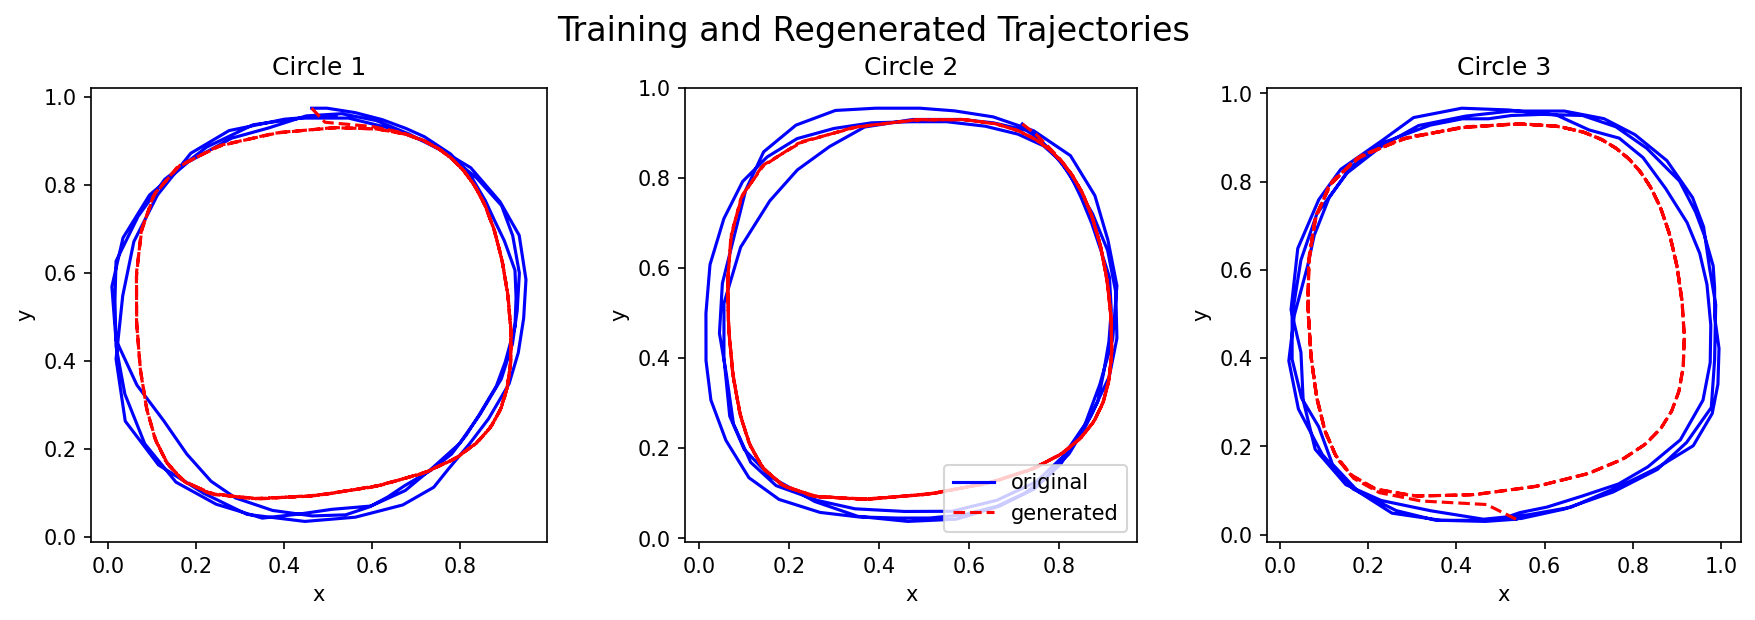

In [632]:
# compute forward propagation predictions for each circle
circgen1, circ1_cs = circle_rnn.fwd_prop(circle1[:, 0], circle1.shape[1]-1, 'circle1')
circgen2, circ2_cs = circle_rnn.fwd_prop(circle2[:, 0], circle2.shape[1]-1, 'circle2')
circgen3, circ3_cs = circle_rnn.fwd_prop(circle3[:, 0], circle3.shape[1]-1, 'circle3')
print("Circle 1 Mean Loss: {:.4f}".format(meanloss(circle1, circgen1)))
print("Circle 2 Mean Loss: {:.4f}".format(meanloss(circle2, circgen2))) 
print("Circle 3 Mean Loss: {:.4f}".format(meanloss(circle3, circgen3)))

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
fig.suptitle('Training and Regenerated Trajectories', fontsize=16)

# plot for circle 1
axs[0].plot(circle1[0], circle1[1], 'b-', label='original')
axs[0].plot(circgen1[0], circgen1[1], 'r--', label='generated')
axs[0].set_title('Circle 1')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal', adjustable='box')
# plot for circle 2
axs[1].plot(circle2[0], circle2[1], 'b-', label='original')
axs[1].plot(circgen2[0], circgen2[1], 'r--', label='generated')
axs[1].set_title('Circle 2')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_aspect('equal', adjustable='box')
axs[1].legend(loc='lower right')
# plot for circle 3
axs[2].plot(circle3[0], circle3[1], 'b-', label='original')
axs[2].plot(circgen3[0], circgen3[1], 'r--', label='generated')
axs[2].set_title('Circle 3')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

Mean Loss: 0.0021


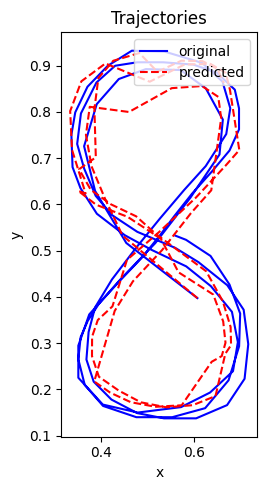

In [605]:
# fwd_prop over ribbon segments and keep concatenating the results
ribbon_traj = np.empty((2, 0), dtype=float)
ribbon_traj = np.concatenate((ribbon_traj, ribbon[:, 0].reshape(-1,1)), axis=1)
for i in range(len(ribbon_segments)):
    seg_traj, _ = ribbon_rnn.fwd_prop(ribbon_segments[i][:, 0], 5, 'r'+str(i))
    ribbon_traj = np.concatenate((ribbon_traj, seg_traj[:, 1:]), axis=1)
print("Mean Loss: {:.4f}".format(meanloss(ribbon[:, 0:ribbon_traj.shape[1]], ribbon_traj)))
# plot the trajectories for comparison
plt.figure(figsize=(5, 5))
plt.plot(ribbon[0], ribbon[1], 'b-', label='original')
plt.plot(ribbon_traj[0], ribbon_traj[1], 'r--', label='predicted')
plt.title('Trajectories')
plt.legend(loc='upper right')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

Mean Loss: 0.1238


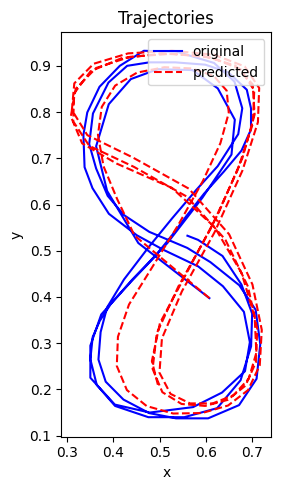

In [578]:
# forward propagate over the entire ribbon
ribbon_traj, ribbon_cs = ribbon_rnn.fwd_prop(ribbon[:, 0], ribbon.shape[1]-1, 'r0')
print("Mean Loss: {:.4f}".format(meanloss(ribbon, ribbon_traj)))
# plot the trajectories for comparison
plt.figure(figsize=(5, 5))
plt.plot(ribbon[0], ribbon[1], 'b-', label='original')
plt.plot(ribbon_traj[0], ribbon_traj[1], 'r--', label='predicted')
plt.title('Trajectories')
plt.legend(loc='upper right')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

Circle 1 Mean Loss: 0.0042
Circle 2 Mean Loss: 0.0080


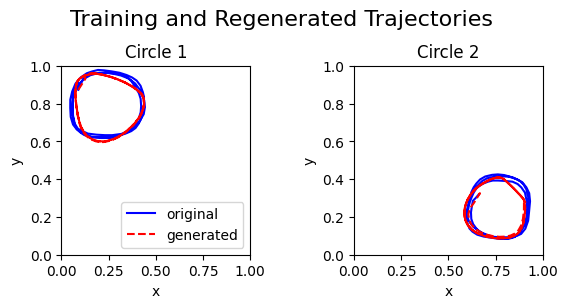

In [603]:
# compute forward propagation predictions for each circle
lcirc1, lcirc1_cs = loccircle_rnn.fwd_prop(loccircle1[:, 0], loccircle1.shape[1]-1, 'circle1')
lcirc2, lcirc2_cs = loccircle_rnn.fwd_prop(loccircle2[:, 0], loccircle2.shape[1]-1, 'circle2')
print("Circle 1 Mean Loss: {:.4f}".format(meanloss(loccircle1, lcirc1)))
print("Circle 2 Mean Loss: {:.4f}".format(meanloss(loccircle2, lcirc2)))

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
fig.suptitle('Training and Regenerated Trajectories', fontsize=16)

# plot for circle 1
axs[0].plot(loccircle1[0], loccircle1[1], 'b-', label='original')
axs[0].plot(lcirc1[0], lcirc1[1], 'r--', label='generated')
axs[0].set_title('Circle 1')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].set_aspect('equal', adjustable='box')
axs[0].legend(loc='lower right')
# plot for circle 2
axs[1].plot(loccircle2[0], loccircle2[1], 'b-', label='original')
axs[1].plot(lcirc2[0], lcirc2[1], 'r--', label='generated')
axs[1].set_title('Circle 2')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)
axs[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

## 5. Basic Network State Analysis

### 5.1 Context Evolution
We can see how the context state evolves to understand the role it plays over the different training trajectories for a given network. We start with the circles.

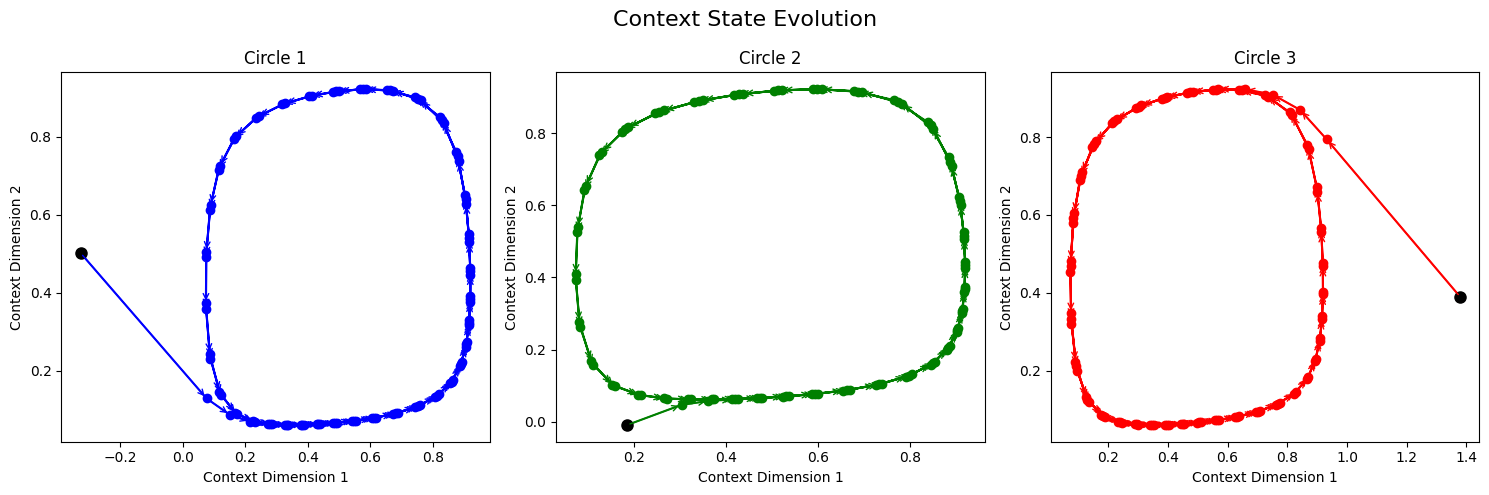

In [627]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Context State Evolution', fontsize=16)
context_states = [circ1_cs, circ2_cs, circ3_cs]
colors = ['blue', 'green', 'red']
titles = ['Circle 1', 'Circle 2', 'Circle 3']

for ax, cs, color, title in zip(axs, context_states, colors, titles):
    # plot cs in step sequence
    ax.plot(cs[0], cs[1], color=color, marker='o', linestyle='-')
    # mark initial context state with a black dot
    ax.plot(cs[0, 0], cs[1, 0], 'ko', markersize=8)
    # arrows between consecutive points to indicate evolution
    for i in range(cs.shape[1] - 1):
        ax.annotate(
            '',
            xy=(cs[0, i+1], cs[1, i+1]),
            xytext=(cs[0, i], cs[1, i]),
            arrowprops=dict(arrowstyle='->', color=color, lw=1)
        )
    ax.set_title(title)
    ax.set_xlabel('Context Dimension 1')
    ax.set_ylabel('Context Dimension 2')
    
plt.tight_layout()
plt.show()

Notice how the same ring attractor produces all three trajectories with the initial contexts being organized according to the respective initial positions.

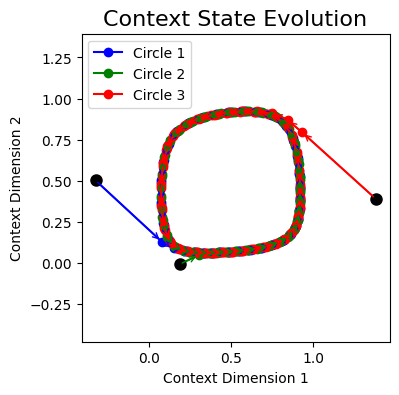

In [629]:
plt.figure(figsize=(4, 4))
plt.title('Context State Evolution', fontsize=16)

context_states = [circ1_cs, circ2_cs, circ3_cs]
colors = ['blue', 'green', 'red']
titles = ['Circle 1', 'Circle 2', 'Circle 3']

for cs, color, title in zip(context_states, colors, titles):
    # plot cs
    plt.plot(cs[0], cs[1], color=color, marker='o', linestyle='-', label=title)
    plt.plot(cs[0, 0], cs[1, 0], 'ko', markersize=8)
    # add arrows between consecutive points
    for i in range(cs.shape[1] - 1):
        plt.annotate(
            '',
            xy=(cs[0, i+1], cs[1, i+1]),
            xytext=(cs[0, i], cs[1, i]),
            arrowprops=dict(arrowstyle='->', color=color, lw=1)
        )

plt.xlabel('Context Dimension 1')
plt.ylabel('Context Dimension 2')
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_box_aspect(1)
plt.legend(loc='upper left')
plt.show()

Now we will see how the context states evolve for all ribbon segments and the single complete run using the first segment's context.

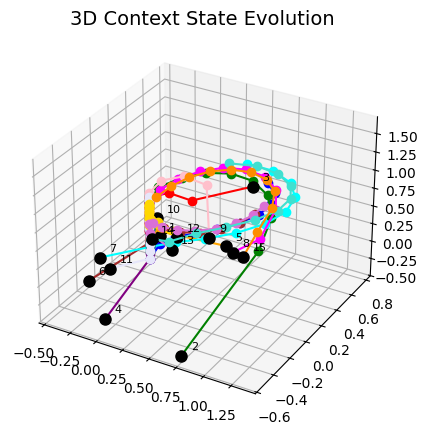

In [ ]:
# get context states
seg_cs = [None]*len(ribbon_segments)
for i in range(len(ribbon_segments)):
    _, seg_cs[i] = ribbon_rnn.fwd_prop(ribbon_segments[i][:, 0], 10, 'r'+str(i))
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D Context State Evolution', fontsize=14)

# colors for each segment
colors = ['blue','green','red','purple','orange','brown','cyan','magenta', 'pink',
          'teal','lavender', 'gold','orchid','turquoise','darkorange', 'skyblue']

# plot each context segment
for i, cs in enumerate(seg_cs):
    color = colors[i % len(colors)]
    x, y, z = cs[1], cs[2], cs[4]
    ax.plot(x, y, z, color=color, marker='o', linestyle='-',
            label=f'Segment {i+1}')
    ax.plot([x[0]], [y[0]], [z[0]], 'ko', markersize=8)
    ax.text(x[0] + 0.05, y[0] + 0.05, z[0] + 0.05, str(i+1), color='black', fontsize=8)
plt.show()

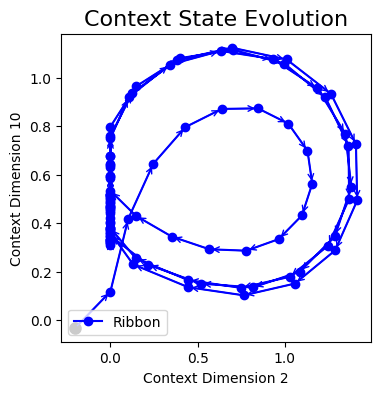

In [589]:
# plot ribbon context evolution (single, complete run)
plt.figure(figsize=(4, 4))
plt.title('Context State Evolution', fontsize=16)

m = 1
n = 9
plt.plot(ribbon_cs[m], ribbon_cs[n], color='blue', marker='o', linestyle='-', label='Ribbon')
plt.plot(ribbon_cs[m, 0], ribbon_cs[n, 0], 'ko', markersize=8)

# add arrows between consecutive points
for i in range(ribbon_cs.shape[1] - 1):
    plt.annotate(
        '',
        xy=(ribbon_cs[m, i+1], ribbon_cs[n, i+1]), 
        xytext=(ribbon_cs[m, i], ribbon_cs[n, i]),
        arrowprops=dict(arrowstyle='->', color='blue', lw=1)
    )

plt.xlabel('Context Dimension '+ str(m+1))
plt.ylabel('Context Dimension ' + str(n+1))
plt.legend(loc='lower left')
plt.show()

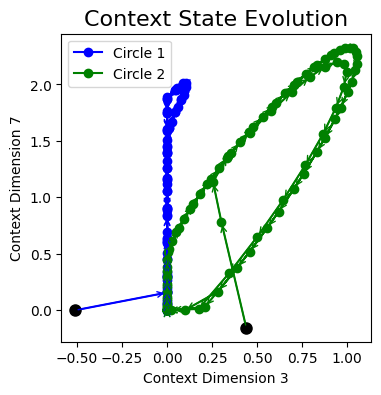

In [643]:
plt.figure(figsize=(4, 4))
plt.title('Context State Evolution', fontsize=16)

context_states = [lcirc1_cs, lcirc2_cs]
colors = ['blue', 'green']
titles = ['Circle 1', 'Circle 2']

for cs, color, title in zip(context_states, colors, titles):
    # plot cs
    m = 2
    n = 6
    plt.plot(cs[m], cs[n], color=color, marker='o', linestyle='-', label=title)
    plt.plot(cs[m, 0], cs[n, 0], 'ko', markersize=8)
    # add arrows between consecutive points
    for i in range(cs.shape[1] - 1):
        plt.annotate(
            '',
            xy=(cs[m, i+1], cs[n, i+1]),
            xytext=(cs[m, i], cs[n, i]),
            arrowprops=dict(arrowstyle='->', color=color, lw=1)
        )

plt.xlabel('Context Dimension '+ str(m+1))
plt.ylabel('Context Dimension ' + str(n+1))
plt.legend(loc='upper left')
plt.show()

### 5.2 Initial Condition Sensitivity
We will plot trajectories over different initial conditions to assess the underlying attractor dynamics in the trained RNNs. A similar analysis could also be done for different values of the initial context state.

In [660]:
def trajectory_field(rnn, seqID, T=33, grid_size=20):
    """
    visualizes trajectories of length T starting from a grid of initial 
    2D positions in [0,1] x [0,1], showing how the RNN evolves different
    initial conditions over time
    """
    # create grid points
    x = np.linspace(0.01, 0.99, grid_size)
    y = np.linspace(0.01, 0.99, grid_size)
    X, Y = np.meshgrid(x, y)
    plt.figure(figsize=(4, 4))
    
    # generate and plot trajectories from each initial condition
    for i in range(grid_size):
        for j in range(grid_size):
            x0 = np.array([X[i,j], Y[i,j]])
            traj, _ = rnn.fwd_prop(x0, T, seqID)
            # plot trajectory with color gradient indicating time progression
            for t in range(len(traj[0])-1):
                plt.plot(traj[0][t:t+2], traj[1][t:t+2], 
                        color=plt.cm.viridis(t/float(len(traj[0])-1)),
                        alpha=0.1)
    
    plt.xlabel("x")
    plt.ylabel("y") 
    plt.title("Trajectory Field")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal')
    plt.show()

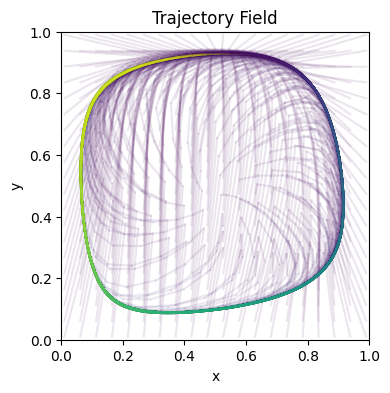

In [661]:
trajectory_field(circle_rnn, 'circle1')

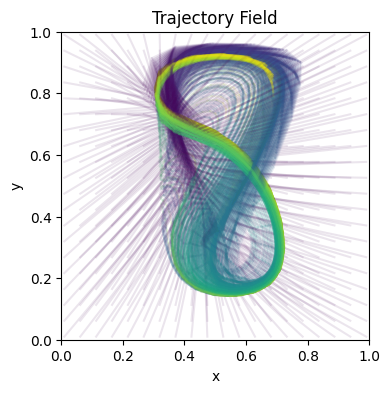

In [668]:
trajectory_field(ribbon_rnn, 'r0')

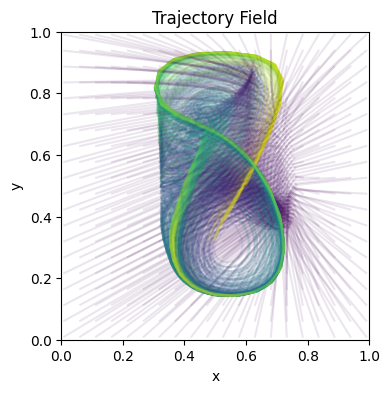

In [669]:
trajectory_field(ribbon_rnn, 'r8')

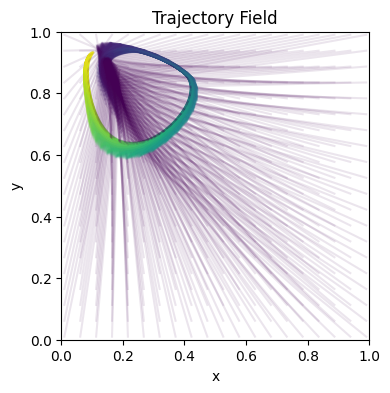

In [670]:
trajectory_field(loccircle_rnn, 'circle1')

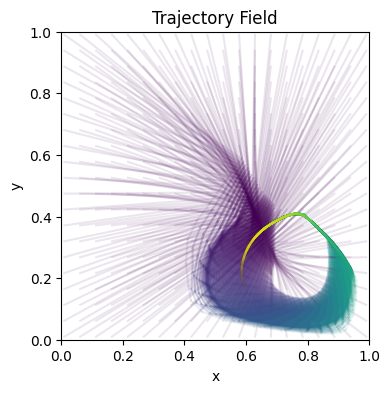

In [665]:
trajectory_field(loccircle_rnn, 'circle2')

In [666]:
# save trained rnns
def save_model(model, save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, "wb") as f:
        pickle.dump(model, f)

save_model(circle_rnn, "./models/circle_rnn.pkl")
save_model(ribbon_rnn, "./models/ribbon_rnn.pkl") 
save_model(loccircle_rnn, "./models/loccircle_rnn.pkl")

In [667]:
# load trained rnns
def load_model(save_path):
    with open(save_path, "rb") as f:
        model = pickle.load(f)
    return model

circle_rnn = load_model("./models/circle_rnn.pkl")
ribbon_rnn = load_model("./models/ribbon_rnn.pkl")
loccircle_rnn = load_model("./models/loccircle_rnn.pkl")